#### Splitting the images data; 70% for train, 15% validation and 15% Test.



In [4]:
# Add this at the top of your notebook to debug
import os
from pathlib import Path

# Check current working directory
print("Current working directory:", os.getcwd())
print("\n" + "="*70)

# Check if data directory exists
print("Checking directory structure:")
print(f"'data' exists: {Path('data').exists()}")
print(f"'data/images' exists: {Path('data/images').exists()}")
print(f"'data/masks' exists: {Path('data/masks').exists()}")

# List what's actually in data/
if Path('data').exists():
    print("\nContents of 'data/':")
    for item in Path('data').iterdir():
        print(f"  - {item.name}")
        if item.is_dir():
            count = len(list(item.iterdir()))
            print(f"    ({count} items inside)")

# Try alternate path - maybe images are in ./images directly?
print(f"\n'./images' exists: {Path('./images').exists()}")
print(f"'./masks' exists: {Path('./masks').exists()}")

Current working directory: c:\Users\Sphamandla\OneDrive\Desktop\CV\projects\a-thousand-piece-mystery\notebooks

Checking directory structure:
'data' exists: False
'data/images' exists: False
'data/masks' exists: False

'./images' exists: False
'./masks' exists: False


PUZZLE DATASET EXPLORATION

Total images found: 1000
Total masks found: 500

✓ Labeled images (with masks): 500
✓ Unlabeled images (no masks): 500

Verifying labeled data integrity...
✓ All labeled images have corresponding masks

SAMPLE VISUALIZATION


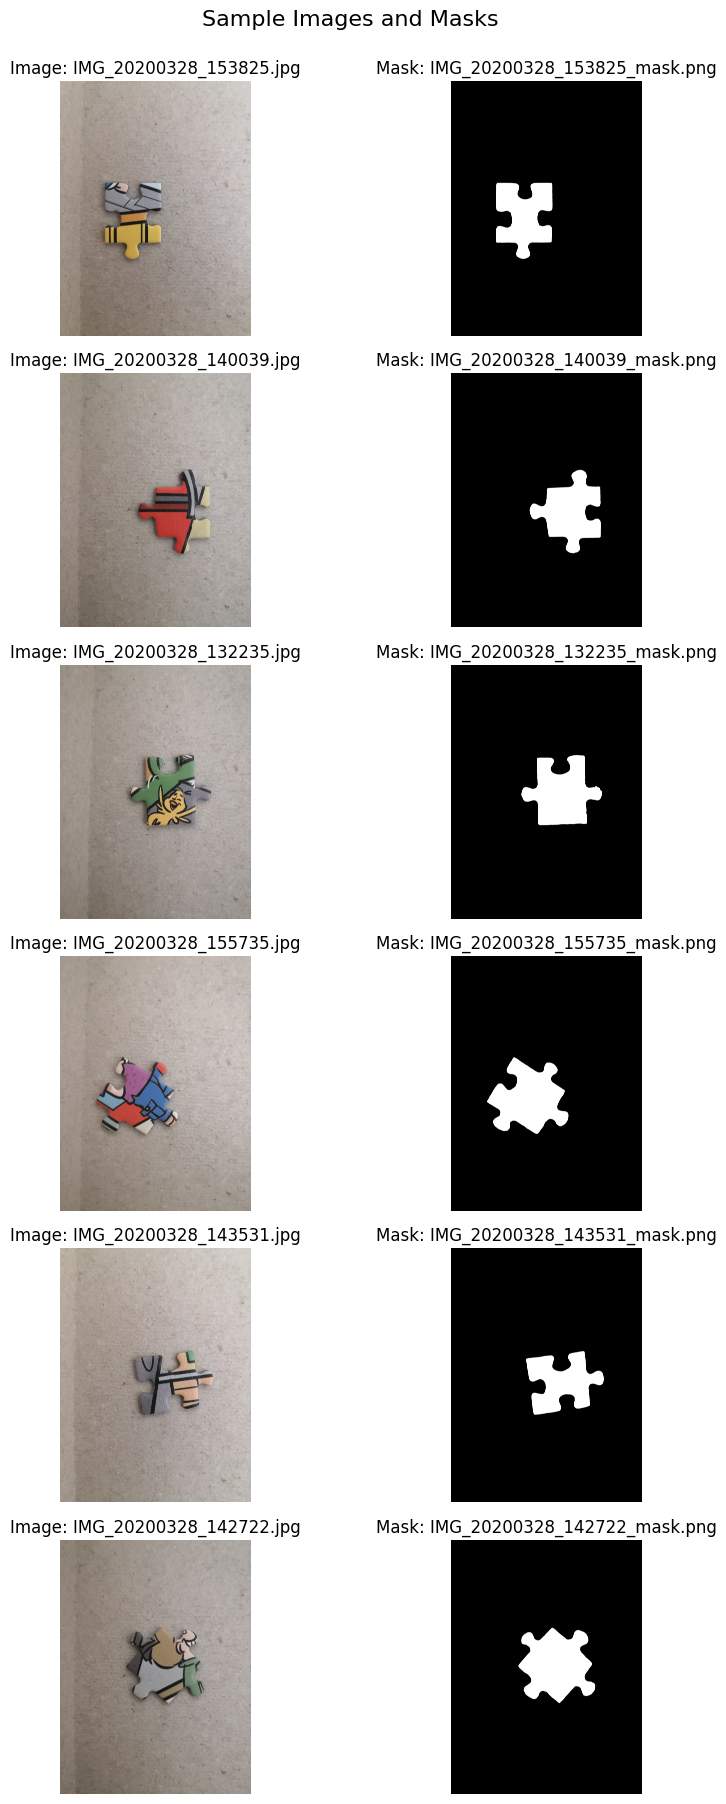

✓ Sample visualization saved to output/visualizations/

IMAGE STATISTICS

Analyzing image dimensions...

Image dimensions (sampled 100 images):
  Width  - Min: 3840, Max: 3840, Mean: 3840
  Height - Min: 5120, Max: 5120, Mean: 5120

Unique image sizes: 1
✓ All images have the same size: [3840 5120]

MASK ANALYSIS

Analyzing mask properties (sampling 50 masks)...

Mask unique values found: {(0, 255)}
Piece coverage statistics:
  Mean: 6.39%
  Min: 4.85%
  Max: 8.36%
  Std: 0.86%

DATA SPLITTING

Split from 500 labeled images:
  Training:   350 images (70.0%)
  Validation: 75 images (15.0%)
  Test:       75 images (15.0%)

Unlabeled (for final submission): 500 images

✓ Created split directories

Copying files to split directories...
  ✓ Training: 350 image-mask pairs copied
  ✓ Validation: 75 image-mask pairs copied
  ✓ Test: 75 image-mask pairs copied

✓ Data splitting complete!

SAVING SPLIT METADATA
✓ Split metadata saved to data/split_info.json

SUMMARY

Dataset Overview:
  Total im

In [7]:
# Data Exploration and Splitting
# This notebook explores the puzzle piece dataset and creates train/val/test splits

import os
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from collections import Counter

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# =============================================================================
# 1. DATA EXPLORATION
# =============================================================================

print("="*70)
print("PUZZLE DATASET EXPLORATION")
print("="*70)

# Define paths (navigate up from notebooks directory)
images_dir = Path("../data/images")
masks_dir = Path("../data/masks")

# Get all images and masks
all_images = sorted(list(images_dir.glob("*.jpg")))
all_masks = sorted(list(masks_dir.glob("*.png")))

print(f"\nTotal images found: {len(all_images)}")
print(f"Total masks found: {len(all_masks)}")

# Identify labeled vs unlabeled data
labeled_images = []
unlabeled_images = []

for img_path in all_images:
    # Check if corresponding mask exists
    mask_name = img_path.stem + "_mask.png"
    mask_path = masks_dir / mask_name
    
    if mask_path.exists():
        labeled_images.append(img_path)
    else:
        unlabeled_images.append(img_path)

print(f"\n✓ Labeled images (with masks): {len(labeled_images)}")
print(f"✓ Unlabeled images (no masks): {len(unlabeled_images)}")

# Verify the labeled images have corresponding masks
print("\nVerifying labeled data integrity...")
missing_masks = []
for img_path in labeled_images:
    mask_name = img_path.stem + "_mask.png"
    mask_path = masks_dir / mask_name
    if not mask_path.exists():
        missing_masks.append(img_path.name)

if missing_masks:
    print(f"⚠ Warning: {len(missing_masks)} images missing masks")
    print(missing_masks[:5])
else:
    print("✓ All labeled images have corresponding masks")

# =============================================================================
# 2. SAMPLE VISUALIZATION
# =============================================================================

print("\n" + "="*70)
print("SAMPLE VISUALIZATION")
print("="*70)

# Display a few random samples
n_samples = 6
sample_indices = random.sample(range(len(labeled_images)), n_samples)

# Create output directory if it doesn't exist
Path('../output/visualizations').mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(n_samples, 2, figsize=(10, 3*n_samples))
fig.suptitle('Sample Images and Masks', fontsize=16, y=1.00)

for idx, sample_idx in enumerate(sample_indices):
    img_path = labeled_images[sample_idx]
    mask_path = masks_dir / (img_path.stem + "_mask.png")
    
    # Load image and mask
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    # Display
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f'Image: {img_path.name}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(mask, cmap='gray')
    axes[idx, 1].set_title(f'Mask: {mask_path.name}')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.savefig('../output/visualizations/sample_images_masks.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Sample visualization saved to output/visualizations/")

# =============================================================================
# 3. IMAGE STATISTICS
# =============================================================================

print("\n" + "="*70)
print("IMAGE STATISTICS")
print("="*70)

# Analyze image dimensions
print("\nAnalyzing image dimensions...")
image_sizes = []
mask_sizes = []

for img_path in labeled_images[:100]:  # Sample 100 for speed
    img = Image.open(img_path)
    image_sizes.append(img.size)
    
    mask_path = masks_dir / (img_path.stem + "_mask.png")
    mask = Image.open(mask_path)
    mask_sizes.append(mask.size)

image_sizes = np.array(image_sizes)
mask_sizes = np.array(mask_sizes)

print(f"\nImage dimensions (sampled {len(image_sizes)} images):")
print(f"  Width  - Min: {image_sizes[:, 0].min()}, Max: {image_sizes[:, 0].max()}, Mean: {image_sizes[:, 0].mean():.0f}")
print(f"  Height - Min: {image_sizes[:, 1].min()}, Max: {image_sizes[:, 1].max()}, Mean: {image_sizes[:, 1].mean():.0f}")

# Check if all images have same dimensions
unique_sizes = np.unique(image_sizes, axis=0)
print(f"\nUnique image sizes: {len(unique_sizes)}")
if len(unique_sizes) == 1:
    print(f"✓ All images have the same size: {unique_sizes[0]}")
else:
    print(f"⚠ Images have varying sizes")
    print("Most common sizes:")
    size_counter = Counter(map(tuple, image_sizes))
    for size, count in size_counter.most_common(5):
        print(f"  {size}: {count} images")

# =============================================================================
# 4. MASK ANALYSIS
# =============================================================================

print("\n" + "="*70)
print("MASK ANALYSIS")
print("="*70)

# Analyze mask values and coverage
print("\nAnalyzing mask properties (sampling 50 masks)...")
mask_coverages = []
unique_values_list = []

for mask_path in random.sample(list(masks_dir.glob("*.png")), 50):
    mask = np.array(Image.open(mask_path))
    
    # Check unique values
    unique_vals = np.unique(mask)
    unique_values_list.append(tuple(unique_vals))
    
    # Calculate coverage (percentage of pixels that are piece)
    if len(unique_vals) == 2:
        coverage = (mask > 0).sum() / mask.size * 100
        mask_coverages.append(coverage)

print(f"\nMask unique values found: {set(unique_values_list)}")
print(f"Piece coverage statistics:")
print(f"  Mean: {np.mean(mask_coverages):.2f}%")
print(f"  Min: {np.min(mask_coverages):.2f}%")
print(f"  Max: {np.max(mask_coverages):.2f}%")
print(f"  Std: {np.std(mask_coverages):.2f}%")

# =============================================================================
# 5. DATA SPLITTING (70% Train, 15% Val, 15% Test)
# =============================================================================

print("\n" + "="*70)
print("DATA SPLITTING")
print("="*70)

# Shuffle labeled data
labeled_images_shuffled = labeled_images.copy()
random.shuffle(labeled_images_shuffled)

# Calculate split sizes
n_labeled = len(labeled_images_shuffled)
n_train = int(0.70 * n_labeled)  # 70%
n_val = int(0.15 * n_labeled)    # 15%
n_test = n_labeled - n_train - n_val  # Remaining (~15%)

print(f"\nSplit from {n_labeled} labeled images:")
print(f"  Training:   {n_train} images ({n_train/n_labeled*100:.1f}%)")
print(f"  Validation: {n_val} images ({n_val/n_labeled*100:.1f}%)")
print(f"  Test:       {n_test} images ({n_test/n_labeled*100:.1f}%)")
print(f"\nUnlabeled (for final submission): {len(unlabeled_images)} images")

# Split the data
train_images = labeled_images_shuffled[:n_train]
val_images = labeled_images_shuffled[n_train:n_train+n_val]
test_images = labeled_images_shuffled[n_train+n_val:]

# Create split directories
split_dirs = {
    'train': ('../data/train/images', '../data/train/masks'),
    'val': ('../data/val/images', '../data/val/masks'),
    'test': ('../data/test/images', '../data/test/masks'),
}

# Create directories
for split_name, (img_dir, mask_dir) in split_dirs.items():
    Path(img_dir).mkdir(parents=True, exist_ok=True)
    Path(mask_dir).mkdir(parents=True, exist_ok=True)

print("\n✓ Created split directories")

# Copy files to respective splits
print("\nCopying files to split directories...")

def copy_split(image_list, img_dest, mask_dest, split_name):
    """Copy images and masks to destination directories."""
    for img_path in image_list:
        # Copy image
        shutil.copy2(img_path, img_dest / img_path.name)
        
        # Copy corresponding mask
        mask_name = img_path.stem + "_mask.png"
        mask_path = masks_dir / mask_name
        shutil.copy2(mask_path, mask_dest / mask_name)
    
    print(f"  ✓ {split_name}: {len(image_list)} image-mask pairs copied")

# Copy training set
copy_split(train_images, 
           Path(split_dirs['train'][0]), 
           Path(split_dirs['train'][1]), 
           'Training')

# Copy validation set
copy_split(val_images, 
           Path(split_dirs['val'][0]), 
           Path(split_dirs['val'][1]), 
           'Validation')

# Copy test set
copy_split(test_images, 
           Path(split_dirs['test'][0]), 
           Path(split_dirs['test'][1]), 
           'Test')

print("\n✓ Data splitting complete!")

# =============================================================================
# 6. SAVE SPLIT INFORMATION
# =============================================================================

print("\n" + "="*70)
print("SAVING SPLIT METADATA")
print("="*70)

import json

# Create data directory for split_info if needed
Path('../data').mkdir(parents=True, exist_ok=True)

# Save split information for reproducibility
split_info = {
    'seed': SEED,
    'total_labeled': n_labeled,
    'total_unlabeled': len(unlabeled_images),
    'splits': {
        'train': {
            'count': n_train,
            'percentage': n_train/n_labeled*100,
            'files': [img.name for img in train_images]
        },
        'val': {
            'count': n_val,
            'percentage': n_val/n_labeled*100,
            'files': [img.name for img in val_images]
        },
        'test': {
            'count': n_test,
            'percentage': n_test/n_labeled*100,
            'files': [img.name for img in test_images]
        }
    },
    'unlabeled_files': [img.name for img in unlabeled_images]
}

# Save to JSON
with open('../data/split_info.json', 'w') as f:
    json.dump(split_info, f, indent=2)

print("✓ Split metadata saved to data/split_info.json")

# =============================================================================
# 7. SUMMARY
# =============================================================================

print("\n" + "="*70)
print("SUMMARY")
print("="*70)

print(f"""
Dataset Overview:
  Total images:              {len(all_images)}
  Labeled (with masks):      {len(labeled_images)}
  Unlabeled (no masks):      {len(unlabeled_images)}

Data Split (from 500 labeled images):
  Training set:              {n_train} images (70%)
  Validation set:            {n_val} images (15%)
  Test set:                  {n_test} images (15%)

Directory Structure:
  data/train/images/         ← {n_train} training images
  data/train/masks/          ← {n_train} training masks
  data/val/images/           ← {n_val} validation images
  data/val/masks/            ← {n_val} validation masks
  data/test/images/          ← {n_test} test images
  data/test/masks/           ← {n_test} test masks

Unlabeled Data (for final submission):
  data/images/               ← 500 unlabeled images (no masks)

Next Steps:
  1. Train segmentation model on training set
  2. Tune hyperparameters using validation set
  3. Evaluate final model on test set
  4. Generate predictions for 500 unlabeled images for submission
""")

print("="*70)
print("✓ Data exploration and splitting complete!")
print("="*70)